`wu_rand_tau_rand_phase_NN_training.ipynb`

In [33]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data_path = 'data/wrap_data_rand_tau_rand_phase_10000.csv'
data_df = pd.read_csv(data_path, dtype = float)

training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

X_training = training_data_df.drop('slope', axis = 1).values
Y_training = training_data_df[['slope']].values

X_testing = testing_data_df.drop('slope', axis = 1).values
Y_testing = testing_data_df[['slope']].values

X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [34]:
import tensorflow as tf

In [35]:
import sys

In [36]:
learning_rate = 0.0015
training_epochs = 2500

layer_1_nodes = 115
layer_2_nodes = 280
layer_3_nodes = 160

In [37]:
logdir = 'rand_tau_rand_phase_10000/'
layer_code = '115_280_160_a'

In [38]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

In [39]:
saver = tf.train.Saver()

with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + layer_code + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + layer_code + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        training_feed = {X: X_scaled_training, Y: Y_scaled_training}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {} training_cost: {}'.format(epoch, training_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + layer_code + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

 epoch: 2499 training_cost: 4.060926949023269e-055

In [40]:
with tf.Session() as session:
    saver.restore(session,'logs/rand_tau_rand_phase_10000/115_280_160_a_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing})
    prediction_unscaled = Y_scaler.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/rand_tau_rand_phase_10000/115_280_160_a_model/trained_model.ckpt


In [41]:
prediction_scaled.T[0][0:10]

array([0.8709155 , 0.74377584, 0.5573994 , 0.41792035, 0.8966483 ,
       0.5481466 , 0.97134805, 0.14683822, 0.9208999 , 0.39718887],
      dtype=float32)

In [42]:
Y_scaled_testing.T[0][0:10]

array([0.875, 0.75 , 0.575, 0.425, 0.9  , 0.55 , 0.975, 0.15 , 0.925,
       0.4  ])

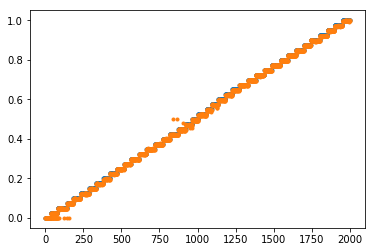

In [43]:
import matplotlib.pyplot as plt

idx = np.argsort(Y_scaled_testing.T[0])
plt.plot(Y_scaled_testing.T[0][idx], ls = 'none', marker = '.')
plt.plot(prediction_scaled.T[0][idx], ls = 'none', marker = '.')
plt.show()

In [44]:
sum((prediction_scaled.T[0] - Y_scaled_testing.T[0])**2)

0.07892538294487406